In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import ViTModel
import time
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms

# Image Fetching and Split

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

# ========================================================================
# 1. Dataset Configuration
# ========================================================================
dataset_paths = {
    'Normal': '/content/drive/MyDrive/Normal and Osteoporosis Binary Classification Dataset/normal/',
    'Osteoporosis': '/content/drive/MyDrive/Normal and Osteoporosis Binary Classification Dataset/osteoporosis/'
}

# ========================================================================
# 2. Image Loading & Preprocessing (for Inception v2)
# ========================================================================
def load_images_and_labels(folder_path, label):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image and verify successful read
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Resize to Inception v2's required 128x128
                img = cv2.resize(img, (128, 128))

                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Normalize to [0, 1] range (for Inception v2)
                img = img.astype(np.float32) / 255.0

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# ========================================================================
# 3. Load and Prepare Data
# ========================================================================
# Load datasets
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], 0)
osteo_images, osteo_labels = load_images_and_labels(dataset_paths['Osteoporosis'], 1)

# Combine and shuffle data
x_data = np.concatenate([normal_images, osteo_images], axis=0)
y_data = np.concatenate([normal_labels, osteo_labels], axis=0)

# Random shuffle with fixed seed for reproducibility
np.random.seed(42)
shuffle_idx = np.random.permutation(len(x_data))
x_data = x_data[shuffle_idx]
y_data = y_data[shuffle_idx]

# ========================================================================
# 4. Train/Validation/Test Split
# ========================================================================
# Stratified split to maintain class balance
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.1,  # 10% of training for validation
    stratify=y_train_val,
    random_state=42
)


Mounted at /content/drive


In [ ]:
print(f'Number of Normal Images: {len(normal_images)}')
print(f'Number of Oestroporosis Images: {len(osteo_images)}')

Number of Normal Images: 186
Number of Oestroporosis Images: 186


In [ ]:
# Define the transform: Resize 128x128 to 224x224
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy to PIL image
    transforms.Resize((224, 224)),  # Resize to ViT input size (224, 224)
    transforms.ToTensor(),  # Convert to tensor, automatically scales to (0, 1)
])

class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform  # Apply transforms if provided

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = self.x_data[idx]  # Shape: (128, 128, 3) NumPy array
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return image, label

# ViT Base

In [ ]:
# Modified ViT Model without DWT Processing
class ViTBinaryClassifier(nn.Module):
    def __init__(self, pretrained_model='google/vit-base-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.vit.config.hidden_size, 1)  # Output for binary classification
        self.sigmoid = nn.Sigmoid()
        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Directly use the input images
        outputs = self.vit(x)
        # Use the output of the [CLS] token for classification
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.sigmoid(self.classifier(cls_output))

# Step 6: Create Datasets and DataLoaders
# (Assuming x_train, y_train, x_val, y_val, x_test, y_test are defined)
batch_size = 32
train_dataset = NumpyDataset(x_train, y_train, transform=transform)
val_dataset = NumpyDataset(x_val, y_val, transform=transform)
test_dataset = NumpyDataset(x_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 7: Initialize Model (AFTER device is defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTBinaryClassifier().to(device)

# Step 8: Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Shape: (batch_size, 1)
            loss = criterion(outputs.squeeze(), labels)  # Squeeze to match shape
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*batch_size)):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)  # Shape: (batch_size, 1)
                loss = criterion(outputs.squeeze(), labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0.5).float()  # Thresholding for binary classification
                correct += (predicted.squeeze() == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        improvement_msg = f"(▼ {best_val_loss - epoch_val_loss:.4f})"
    else:
        epochs_no_improve += 1
        improvement_msg = f"(▲ {epoch_val_loss - best_val_loss:.4f}) [Patience left: {patience - epochs_no_improve}]"
        if epochs_no_improve >= patience:
            early_stop = True

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start
    time_remaining = (epoch_time * (num_epochs - epoch - 1)) / 3600 if not early_stop else 0

    # Detailed epoch report
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Duration: {epoch_time:.1f}s | Remaining: ~{time_remaining:.1f}h")
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} {improvement_msg}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"-"*60)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Shape: (batch_size, 1)
            loss = criterion(outputs.squeeze(), labels)

            test_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()  # Thresholding for binary classification
            test_correct += (predicted.squeeze() == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.69batch/s, Loss=0.6816, Acc=0.8333]



Epoch   1/500 | Duration: 5.5s | Remaining: ~0.8h
Train Loss: 0.6951
Val Loss:   0.6816 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   2/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.20batch/s, Loss=0.6720, Acc=0.5667]



Epoch   2/500 | Duration: 4.2s | Remaining: ~0.6h
Train Loss: 0.6797
Val Loss:   0.6720 (▼ 0.0000)
Val Acc:    0.5667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   3/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.14batch/s, Loss=0.6618, Acc=0.8000]



Epoch   3/500 | Duration: 4.5s | Remaining: ~0.6h
Train Loss: 0.6728
Val Loss:   0.6618 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   4/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.81batch/s, Loss=0.6529, Acc=0.8000]



Epoch   4/500 | Duration: 4.8s | Remaining: ~0.7h
Train Loss: 0.6639
Val Loss:   0.6529 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   5/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.18batch/s, Loss=0.6443, Acc=0.8000]



Epoch   5/500 | Duration: 4.9s | Remaining: ~0.7h
Train Loss: 0.6565
Val Loss:   0.6443 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   6/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.11batch/s, Loss=0.6360, Acc=0.8333]



Epoch   6/500 | Duration: 4.2s | Remaining: ~0.6h
Train Loss: 0.6489
Val Loss:   0.6360 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   7/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.75batch/s, Loss=0.6277, Acc=0.8333]



Epoch   7/500 | Duration: 4.7s | Remaining: ~0.7h
Train Loss: 0.6431
Val Loss:   0.6277 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   8/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.98batch/s, Loss=0.6212, Acc=0.8000]



Epoch   8/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.6358
Val Loss:   0.6212 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   9/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.10batch/s, Loss=0.6145, Acc=0.8000]



Epoch   9/500 | Duration: 4.2s | Remaining: ~0.6h
Train Loss: 0.6319
Val Loss:   0.6145 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  10/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.14batch/s, Loss=0.6074, Acc=0.8667]



Epoch  10/500 | Duration: 4.2s | Remaining: ~0.6h
Train Loss: 0.6270
Val Loss:   0.6074 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  11/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.85batch/s, Loss=0.6018, Acc=0.8333]



Epoch  11/500 | Duration: 5.0s | Remaining: ~0.7h
Train Loss: 0.6196
Val Loss:   0.6018 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  12/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.12batch/s, Loss=0.5972, Acc=0.8000]



Epoch  12/500 | Duration: 6.6s | Remaining: ~0.9h
Train Loss: 0.6169
Val Loss:   0.5972 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  13/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.78batch/s, Loss=0.5904, Acc=0.8667]



Epoch  13/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.6097
Val Loss:   0.5904 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  14/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, Loss=0.5848, Acc=0.8667]



Epoch  14/500 | Duration: 4.5s | Remaining: ~0.6h
Train Loss: 0.6054
Val Loss:   0.5848 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  15/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, Loss=0.5807, Acc=0.8000]



Epoch  15/500 | Duration: 4.2s | Remaining: ~0.6h
Train Loss: 0.6014
Val Loss:   0.5807 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  16/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.07batch/s, Loss=0.5751, Acc=0.8667]



Epoch  16/500 | Duration: 4.3s | Remaining: ~0.6h
Train Loss: 0.5971
Val Loss:   0.5751 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  17/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.73batch/s, Loss=0.5703, Acc=0.8000]



Epoch  17/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5926
Val Loss:   0.5703 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  18/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, Loss=0.5650, Acc=0.8000]



Epoch  18/500 | Duration: 4.6s | Remaining: ~0.6h
Train Loss: 0.5892
Val Loss:   0.5650 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  19/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.00batch/s, Loss=0.5609, Acc=0.8000]



Epoch  19/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.5864
Val Loss:   0.5609 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  20/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.72batch/s, Loss=0.5577, Acc=0.8000]



Epoch  20/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5861
Val Loss:   0.5577 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  21/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.5533, Acc=0.8333]



Epoch  21/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.5795
Val Loss:   0.5533 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  22/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.5506, Acc=0.8000]



Epoch  22/500 | Duration: 6.4s | Remaining: ~0.9h
Train Loss: 0.5763
Val Loss:   0.5506 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  23/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.82batch/s, Loss=0.5456, Acc=0.8667]



Epoch  23/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5743
Val Loss:   0.5456 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  24/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, Loss=0.5437, Acc=0.8333]



Epoch  24/500 | Duration: 4.3s | Remaining: ~0.6h
Train Loss: 0.5705
Val Loss:   0.5437 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  25/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.5415, Acc=0.8000]



Epoch  25/500 | Duration: 7.6s | Remaining: ~1.0h
Train Loss: 0.5671
Val Loss:   0.5415 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  26/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.13batch/s, Loss=0.5371, Acc=0.8000]



Epoch  26/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.5651
Val Loss:   0.5371 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  27/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.84batch/s, Loss=0.5339, Acc=0.8667]



Epoch  27/500 | Duration: 4.5s | Remaining: ~0.6h
Train Loss: 0.5624
Val Loss:   0.5339 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  28/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.76batch/s, Loss=0.5316, Acc=0.8000]



Epoch  28/500 | Duration: 4.9s | Remaining: ~0.6h
Train Loss: 0.5595
Val Loss:   0.5316 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  29/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, Loss=0.5304, Acc=0.8000]



Epoch  29/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.5581
Val Loss:   0.5304 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  30/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.11batch/s, Loss=0.5257, Acc=0.8333]



Epoch  30/500 | Duration: 4.6s | Remaining: ~0.6h
Train Loss: 0.5552
Val Loss:   0.5257 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  31/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s, Loss=0.5238, Acc=0.8667]



Epoch  31/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5529
Val Loss:   0.5238 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  32/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.11batch/s, Loss=0.5219, Acc=0.8667]



Epoch  32/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.5515
Val Loss:   0.5219 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  33/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.05batch/s, Loss=0.5200, Acc=0.8333]



Epoch  33/500 | Duration: 4.4s | Remaining: ~0.6h
Train Loss: 0.5500
Val Loss:   0.5200 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  34/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s, Loss=0.5180, Acc=0.8667]



Epoch  34/500 | Duration: 4.9s | Remaining: ~0.6h
Train Loss: 0.5473
Val Loss:   0.5180 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  35/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99batch/s, Loss=0.5157, Acc=0.8333]



Epoch  35/500 | Duration: 4.5s | Remaining: ~0.6h
Train Loss: 0.5456
Val Loss:   0.5157 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  36/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.5136, Acc=0.8667]



Epoch  36/500 | Duration: 4.5s | Remaining: ~0.6h
Train Loss: 0.5436
Val Loss:   0.5136 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  37/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.76batch/s, Loss=0.5121, Acc=0.8667]



Epoch  37/500 | Duration: 11.2s | Remaining: ~1.4h
Train Loss: 0.5424
Val Loss:   0.5121 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  38/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.08batch/s, Loss=0.5099, Acc=0.8333]



Epoch  38/500 | Duration: 22.0s | Remaining: ~2.8h
Train Loss: 0.5406
Val Loss:   0.5099 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  39/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, Loss=0.5080, Acc=0.8333]



Epoch  39/500 | Duration: 7.9s | Remaining: ~1.0h
Train Loss: 0.5386
Val Loss:   0.5080 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  40/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.72batch/s, Loss=0.5064, Acc=0.8667]



Epoch  40/500 | Duration: 5.0s | Remaining: ~0.6h
Train Loss: 0.5379
Val Loss:   0.5064 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  41/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.83batch/s, Loss=0.5068, Acc=0.8000]



Epoch  41/500 | Duration: 4.0s | Remaining: ~0.5h
Train Loss: 0.5356
Val Loss:   0.5068 (▲ 0.0005) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  42/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.5048, Acc=0.8000]



Epoch  42/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5347
Val Loss:   0.5048 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  43/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.5012, Acc=0.8667]



Epoch  43/500 | Duration: 9.7s | Remaining: ~1.2h
Train Loss: 0.5327
Val Loss:   0.5012 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  44/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4999, Acc=0.8333]



Epoch  44/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.5305
Val Loss:   0.4999 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  45/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4998, Acc=0.8000]



Epoch  45/500 | Duration: 9.6s | Remaining: ~1.2h
Train Loss: 0.5298
Val Loss:   0.4998 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  46/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4979, Acc=0.8000]



Epoch  46/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.5283
Val Loss:   0.4979 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  47/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.05batch/s, Loss=0.4959, Acc=0.8667]



Epoch  47/500 | Duration: 4.6s | Remaining: ~0.6h
Train Loss: 0.5274
Val Loss:   0.4959 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  48/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s, Loss=0.4948, Acc=0.8000]



Epoch  48/500 | Duration: 5.0s | Remaining: ~0.6h
Train Loss: 0.5279
Val Loss:   0.4948 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  49/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.95batch/s, Loss=0.4935, Acc=0.8333]



Epoch  49/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.5243
Val Loss:   0.4935 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  50/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.98batch/s, Loss=0.4928, Acc=0.8333]



Epoch  50/500 | Duration: 5.1s | Remaining: ~0.6h
Train Loss: 0.5228
Val Loss:   0.4928 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  51/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.75batch/s, Loss=0.4918, Acc=0.8000]



Epoch  51/500 | Duration: 4.9s | Remaining: ~0.6h
Train Loss: 0.5225
Val Loss:   0.4918 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  52/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4899, Acc=0.8000]



Epoch  52/500 | Duration: 4.5s | Remaining: ~0.6h
Train Loss: 0.5214
Val Loss:   0.4899 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  53/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4897, Acc=0.8000]



Epoch  53/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5219
Val Loss:   0.4897 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  54/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.63batch/s, Loss=0.4875, Acc=0.8667]



Epoch  54/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5192
Val Loss:   0.4875 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  55/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4869, Acc=0.8000]



Epoch  55/500 | Duration: 9.6s | Remaining: ~1.2h
Train Loss: 0.5188
Val Loss:   0.4869 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  56/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.85batch/s, Loss=0.4852, Acc=0.8667]



Epoch  56/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5156
Val Loss:   0.4852 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  57/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4837, Acc=0.8667]



Epoch  57/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5153
Val Loss:   0.4837 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  58/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99batch/s, Loss=0.4830, Acc=0.8667]



Epoch  58/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5142
Val Loss:   0.4830 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  59/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.70batch/s, Loss=0.4824, Acc=0.8333]



Epoch  59/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.5133
Val Loss:   0.4824 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  60/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4819, Acc=0.8000]



Epoch  60/500 | Duration: 4.5s | Remaining: ~0.5h
Train Loss: 0.5122
Val Loss:   0.4819 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  61/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4826, Acc=0.8000]



Epoch  61/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.5120
Val Loss:   0.4826 (▲ 0.0007) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  62/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.68batch/s, Loss=0.4809, Acc=0.8333]



Epoch  62/500 | Duration: 4.9s | Remaining: ~0.6h
Train Loss: 0.5106
Val Loss:   0.4809 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  63/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.05batch/s, Loss=0.4788, Acc=0.8667]



Epoch  63/500 | Duration: 6.0s | Remaining: ~0.7h
Train Loss: 0.5092
Val Loss:   0.4788 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  64/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4779, Acc=0.8000]



Epoch  64/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5105
Val Loss:   0.4779 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  65/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.76batch/s, Loss=0.4761, Acc=0.8667]



Epoch  65/500 | Duration: 4.6s | Remaining: ~0.6h
Train Loss: 0.5084
Val Loss:   0.4761 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  66/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.10batch/s, Loss=0.4766, Acc=0.8000]



Epoch  66/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.5072
Val Loss:   0.4766 (▲ 0.0005) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  67/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.05batch/s, Loss=0.4751, Acc=0.8667]



Epoch  67/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5057
Val Loss:   0.4751 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  68/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s, Loss=0.4743, Acc=0.8667]



Epoch  68/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.5047
Val Loss:   0.4743 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  69/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s, Loss=0.4729, Acc=0.8667]



Epoch  69/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5037
Val Loss:   0.4729 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  70/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, Loss=0.4717, Acc=0.8667]



Epoch  70/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5029
Val Loss:   0.4717 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  71/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s, Loss=0.4710, Acc=0.8667]



Epoch  71/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.5027
Val Loss:   0.4710 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  72/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.05batch/s, Loss=0.4697, Acc=0.8667]



Epoch  72/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.5020
Val Loss:   0.4697 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  73/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4693, Acc=0.8667]



Epoch  73/500 | Duration: 4.3s | Remaining: ~0.5h
Train Loss: 0.5022
Val Loss:   0.4693 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  74/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.72batch/s, Loss=0.4690, Acc=0.8667]



Epoch  74/500 | Duration: 4.9s | Remaining: ~0.6h
Train Loss: 0.4992
Val Loss:   0.4690 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  75/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4691, Acc=0.8667]



Epoch  75/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.5012
Val Loss:   0.4691 (▲ 0.0002) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  76/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4678, Acc=0.8667]



Epoch  76/500 | Duration: 4.3s | Remaining: ~0.5h
Train Loss: 0.4990
Val Loss:   0.4678 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  77/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, Loss=0.4673, Acc=0.8000]



Epoch  77/500 | Duration: 4.5s | Remaining: ~0.5h
Train Loss: 0.4975
Val Loss:   0.4673 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  78/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.68batch/s, Loss=0.4667, Acc=0.8667]



Epoch  78/500 | Duration: 4.7s | Remaining: ~0.6h
Train Loss: 0.4970
Val Loss:   0.4667 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  79/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.07batch/s, Loss=0.4661, Acc=0.8667]



Epoch  79/500 | Duration: 6.3s | Remaining: ~0.7h
Train Loss: 0.4957
Val Loss:   0.4661 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  80/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.70batch/s, Loss=0.4657, Acc=0.8667]



Epoch  80/500 | Duration: 4.8s | Remaining: ~0.6h
Train Loss: 0.4959
Val Loss:   0.4657 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  81/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.81batch/s, Loss=0.4658, Acc=0.8667]



Epoch  81/500 | Duration: 3.9s | Remaining: ~0.5h
Train Loss: 0.4957
Val Loss:   0.4658 (▲ 0.0001) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  82/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4654, Acc=0.8667]



Epoch  82/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.4936
Val Loss:   0.4654 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  83/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.91batch/s, Loss=0.4658, Acc=0.8667]



Epoch  83/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4933
Val Loss:   0.4658 (▲ 0.0004) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  84/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s, Loss=0.4662, Acc=0.8667]



Epoch  84/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4964
Val Loss:   0.4662 (▲ 0.0009) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  85/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.95batch/s, Loss=0.4662, Acc=0.8000]



Epoch  85/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4924
Val Loss:   0.4662 (▲ 0.0008) [Patience left: 17]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  86/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.05batch/s, Loss=0.4660, Acc=0.8000]



Epoch  86/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4913
Val Loss:   0.4660 (▲ 0.0006) [Patience left: 16]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  87/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4638, Acc=0.8667]



Epoch  87/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.4928
Val Loss:   0.4638 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  88/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.65batch/s, Loss=0.4633, Acc=0.8667]



Epoch  88/500 | Duration: 5.0s | Remaining: ~0.6h
Train Loss: 0.4895
Val Loss:   0.4633 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  89/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, Loss=0.4641, Acc=0.8000]



Epoch  89/500 | Duration: 3.9s | Remaining: ~0.4h
Train Loss: 0.4895
Val Loss:   0.4641 (▲ 0.0008) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  90/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99batch/s, Loss=0.4619, Acc=0.8667]



Epoch  90/500 | Duration: 4.4s | Remaining: ~0.5h
Train Loss: 0.4886
Val Loss:   0.4619 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  91/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.75batch/s, Loss=0.4620, Acc=0.8667]



Epoch  91/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4871
Val Loss:   0.4620 (▲ 0.0001) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  92/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.83batch/s, Loss=0.4620, Acc=0.8667]



Epoch  92/500 | Duration: 3.9s | Remaining: ~0.4h
Train Loss: 0.4870
Val Loss:   0.4620 (▲ 0.0002) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  93/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99batch/s, Loss=0.4616, Acc=0.8667]



Epoch  93/500 | Duration: 6.3s | Remaining: ~0.7h
Train Loss: 0.4861
Val Loss:   0.4616 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  94/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.00batch/s, Loss=0.4607, Acc=0.8667]



Epoch  94/500 | Duration: 4.9s | Remaining: ~0.6h
Train Loss: 0.4853
Val Loss:   0.4607 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  95/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.83batch/s, Loss=0.4599, Acc=0.8667]



Epoch  95/500 | Duration: 4.6s | Remaining: ~0.5h
Train Loss: 0.4845
Val Loss:   0.4599 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  96/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.08batch/s, Loss=0.4588, Acc=0.8667]



Epoch  96/500 | Duration: 4.3s | Remaining: ~0.5h
Train Loss: 0.4844
Val Loss:   0.4588 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  97/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, Loss=0.4595, Acc=0.8333]



Epoch  97/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4835
Val Loss:   0.4595 (▲ 0.0006) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  98/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.78batch/s, Loss=0.4609, Acc=0.8000]



Epoch  98/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4846
Val Loss:   0.4609 (▲ 0.0020) [Patience left: 18]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  99/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99batch/s, Loss=0.4587, Acc=0.8333]



Epoch  99/500 | Duration: 37.3s | Remaining: ~4.2h
Train Loss: 0.4835
Val Loss:   0.4587 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 100/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4578, Acc=0.8667]



Epoch 100/500 | Duration: 10.1s | Remaining: ~1.1h
Train Loss: 0.4815
Val Loss:   0.4578 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 101/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.79batch/s, Loss=0.4577, Acc=0.8667]



Epoch 101/500 | Duration: 10.3s | Remaining: ~1.1h
Train Loss: 0.4808
Val Loss:   0.4577 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 102/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.88batch/s, Loss=0.4575, Acc=0.8667]



Epoch 102/500 | Duration: 5.0s | Remaining: ~0.5h
Train Loss: 0.4803
Val Loss:   0.4575 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 103/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.80batch/s, Loss=0.4583, Acc=0.8333]



Epoch 103/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4800
Val Loss:   0.4583 (▲ 0.0008) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 104/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.99batch/s, Loss=0.4566, Acc=0.8667]



Epoch 104/500 | Duration: 19.6s | Remaining: ~2.2h
Train Loss: 0.4795
Val Loss:   0.4566 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 105/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.97batch/s, Loss=0.4561, Acc=0.8667]



Epoch 105/500 | Duration: 5.0s | Remaining: ~0.5h
Train Loss: 0.4785
Val Loss:   0.4561 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 106/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4556, Acc=0.8667]



Epoch 106/500 | Duration: 4.6s | Remaining: ~0.5h
Train Loss: 0.4786
Val Loss:   0.4556 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 107/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s, Loss=0.4549, Acc=0.8333]



Epoch 107/500 | Duration: 5.0s | Remaining: ~0.5h
Train Loss: 0.4786
Val Loss:   0.4549 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 108/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.94batch/s, Loss=0.4544, Acc=0.8333]



Epoch 108/500 | Duration: 4.7s | Remaining: ~0.5h
Train Loss: 0.4777
Val Loss:   0.4544 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 109/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.98batch/s, Loss=0.4540, Acc=0.8333]



Epoch 109/500 | Duration: 4.7s | Remaining: ~0.5h
Train Loss: 0.4771
Val Loss:   0.4540 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 110/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s, Loss=0.4544, Acc=0.8667]



Epoch 110/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4775
Val Loss:   0.4544 (▲ 0.0004) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 111/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.97batch/s, Loss=0.4542, Acc=0.8667]



Epoch 111/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4751
Val Loss:   0.4542 (▲ 0.0002) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 112/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.00batch/s, Loss=0.4547, Acc=0.8333]



Epoch 112/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4747
Val Loss:   0.4547 (▲ 0.0007) [Patience left: 17]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 113/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.69batch/s, Loss=0.4530, Acc=0.8667]



Epoch 113/500 | Duration: 5.0s | Remaining: ~0.5h
Train Loss: 0.4743
Val Loss:   0.4530 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 114/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.84batch/s, Loss=0.4531, Acc=0.8667]



Epoch 114/500 | Duration: 3.9s | Remaining: ~0.4h
Train Loss: 0.4731
Val Loss:   0.4531 (▲ 0.0002) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 115/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4532, Acc=0.8667]



Epoch 115/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4727
Val Loss:   0.4532 (▲ 0.0002) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 116/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4520, Acc=0.8667]



Epoch 116/500 | Duration: 4.6s | Remaining: ~0.5h
Train Loss: 0.4728
Val Loss:   0.4520 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 117/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.63batch/s, Loss=0.4535, Acc=0.8333]



Epoch 117/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4723
Val Loss:   0.4535 (▲ 0.0016) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 118/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4517, Acc=0.8667]



Epoch 118/500 | Duration: 22.5s | Remaining: ~2.4h
Train Loss: 0.4720
Val Loss:   0.4517 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 119/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4522, Acc=0.8667]



Epoch 119/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4703
Val Loss:   0.4522 (▲ 0.0005) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 120/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4517, Acc=0.8667]



Epoch 120/500 | Duration: 17.0s | Remaining: ~1.8h
Train Loss: 0.4697
Val Loss:   0.4517 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 121/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s, Loss=0.4521, Acc=0.8667]



Epoch 121/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4691
Val Loss:   0.4521 (▲ 0.0004) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 122/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, Loss=0.4520, Acc=0.8667]



Epoch 122/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4692
Val Loss:   0.4520 (▲ 0.0003) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 123/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.68batch/s, Loss=0.4533, Acc=0.8333]



Epoch 123/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4691
Val Loss:   0.4533 (▲ 0.0016) [Patience left: 17]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 124/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.70batch/s, Loss=0.4513, Acc=0.8667]



Epoch 124/500 | Duration: 30.7s | Remaining: ~3.2h
Train Loss: 0.4673
Val Loss:   0.4513 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 125/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s, Loss=0.4519, Acc=0.8333]



Epoch 125/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4682
Val Loss:   0.4519 (▲ 0.0006) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 126/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.98batch/s, Loss=0.4526, Acc=0.8667]



Epoch 126/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4662
Val Loss:   0.4526 (▲ 0.0013) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 127/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.69batch/s, Loss=0.4546, Acc=0.8333]



Epoch 127/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4678
Val Loss:   0.4546 (▲ 0.0033) [Patience left: 17]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 128/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.78batch/s, Loss=0.4522, Acc=0.8333]



Epoch 128/500 | Duration: 3.9s | Remaining: ~0.4h
Train Loss: 0.4669
Val Loss:   0.4522 (▲ 0.0008) [Patience left: 16]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 129/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.97batch/s, Loss=0.4519, Acc=0.8333]



Epoch 129/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4654
Val Loss:   0.4519 (▲ 0.0005) [Patience left: 15]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 130/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.98batch/s, Loss=0.4516, Acc=0.8667]



Epoch 130/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4655
Val Loss:   0.4516 (▲ 0.0002) [Patience left: 14]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch 131/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.69batch/s, Loss=0.4515, Acc=0.8667]



Epoch 131/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4638
Val Loss:   0.4515 (▲ 0.0001) [Patience left: 13]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 132/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.79batch/s, Loss=0.4513, Acc=0.8667]



Epoch 132/500 | Duration: 5.0s | Remaining: ~0.5h
Train Loss: 0.4637
Val Loss:   0.4513 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 133/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.94batch/s, Loss=0.4513, Acc=0.8667]



Epoch 133/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4636
Val Loss:   0.4513 (▲ 0.0000) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 134/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.98batch/s, Loss=0.4513, Acc=0.8667]



Epoch 134/500 | Duration: 4.6s | Remaining: ~0.5h
Train Loss: 0.4635
Val Loss:   0.4513 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 135/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.57batch/s, Loss=0.4514, Acc=0.8667]



Epoch 135/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4635
Val Loss:   0.4514 (▲ 0.0001) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 136/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.04batch/s, Loss=0.4515, Acc=0.8667]



Epoch 136/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4635
Val Loss:   0.4515 (▲ 0.0002) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 137/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4515, Acc=0.8667]



Epoch 137/500 | Duration: 3.5s | Remaining: ~0.4h
Train Loss: 0.4635
Val Loss:   0.4515 (▲ 0.0002) [Patience left: 17]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 138/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.95batch/s, Loss=0.4514, Acc=0.8667]



Epoch 138/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4634
Val Loss:   0.4514 (▲ 0.0001) [Patience left: 16]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 139/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.83batch/s, Loss=0.4513, Acc=0.8667]



Epoch 139/500 | Duration: 4.9s | Remaining: ~0.5h
Train Loss: 0.4633
Val Loss:   0.4513 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 140/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.95batch/s, Loss=0.4512, Acc=0.8667]



Epoch 140/500 | Duration: 4.6s | Remaining: ~0.5h
Train Loss: 0.4632
Val Loss:   0.4512 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 141/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.07batch/s, Loss=0.4510, Acc=0.8667]



Epoch 141/500 | Duration: 5.1s | Remaining: ~0.5h
Train Loss: 0.4634
Val Loss:   0.4510 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 142/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.75batch/s, Loss=0.4510, Acc=0.8667]



Epoch 142/500 | Duration: 3.9s | Remaining: ~0.4h
Train Loss: 0.4631
Val Loss:   0.4510 (▲ 0.0000) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 143/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s, Loss=0.4512, Acc=0.8667]



Epoch 143/500 | Duration: 3.5s | Remaining: ~0.4h
Train Loss: 0.4632
Val Loss:   0.4512 (▲ 0.0002) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 144/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s, Loss=0.4512, Acc=0.8667]



Epoch 144/500 | Duration: 3.5s | Remaining: ~0.3h
Train Loss: 0.4631
Val Loss:   0.4512 (▲ 0.0002) [Patience left: 17]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 145/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.71batch/s, Loss=0.4512, Acc=0.8667]



Epoch 145/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4630
Val Loss:   0.4512 (▲ 0.0002) [Patience left: 16]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 146/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.80batch/s, Loss=0.4511, Acc=0.8667]



Epoch 146/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4629
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 15]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 147/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4512, Acc=0.8667]



Epoch 147/500 | Duration: 3.5s | Remaining: ~0.3h
Train Loss: 0.4630
Val Loss:   0.4512 (▲ 0.0002) [Patience left: 14]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch 148/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.96batch/s, Loss=0.4512, Acc=0.8667]



Epoch 148/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4512 (▲ 0.0002) [Patience left: 13]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch 149/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s, Loss=0.4512, Acc=0.8667]



Epoch 149/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4512 (▲ 0.0001) [Patience left: 12]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch 150/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.79batch/s, Loss=0.4512, Acc=0.8667]



Epoch 150/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4512 (▲ 0.0001) [Patience left: 11]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch 151/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4511, Acc=0.8667]



Epoch 151/500 | Duration: 3.6s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 10]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch 152/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s, Loss=0.4511, Acc=0.8667]



Epoch 152/500 | Duration: 3.6s | Remaining: ~0.3h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 9]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch 153/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.74batch/s, Loss=0.4511, Acc=0.8667]



Epoch 153/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 8]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch 154/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.79batch/s, Loss=0.4511, Acc=0.8667]



Epoch 154/500 | Duration: 3.9s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 7]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch 155/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.93batch/s, Loss=0.4511, Acc=0.8667]



Epoch 155/500 | Duration: 3.6s | Remaining: ~0.3h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 6]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch 156/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02batch/s, Loss=0.4511, Acc=0.8667]



Epoch 156/500 | Duration: 3.6s | Remaining: ~0.3h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 5]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch 157/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.76batch/s, Loss=0.4511, Acc=0.8667]



Epoch 157/500 | Duration: 3.7s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 4]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch 158/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.78batch/s, Loss=0.4511, Acc=0.8667]



Epoch 158/500 | Duration: 3.8s | Remaining: ~0.4h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 3]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch 159/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, Loss=0.4511, Acc=0.8667]



Epoch 159/500 | Duration: 3.6s | Remaining: ~0.3h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 2]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch 160/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.06batch/s, Loss=0.4511, Acc=0.8667]



Epoch 160/500 | Duration: 3.6s | Remaining: ~0.3h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 1]
Val Acc:    0.8667
Learning Rate: 1.00e-07
------------------------------------------------------------


Epoch 161/500 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.70batch/s, Loss=0.4511, Acc=0.8667]
<ipython-input-6-ea554c8b544c>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu


Epoch 161/500 | Duration: 3.7s | Remaining: ~0.0h
Train Loss: 0.4628
Val Loss:   0.4511 (▲ 0.0001) [Patience left: 0]
Val Acc:    0.8667
Learning Rate: 1.00e-07
------------------------------------------------------------
[!] Early stopping triggered at epoch 162

Loaded best model weights for final testing


Final Testing: 100%|██████████| 3/3 [00:01<00:00,  2.60batch/s, Loss=0.3690, Acc=0.7333]


Final Test Results:
Loss: 0.4982
Accuracy: 0.7333


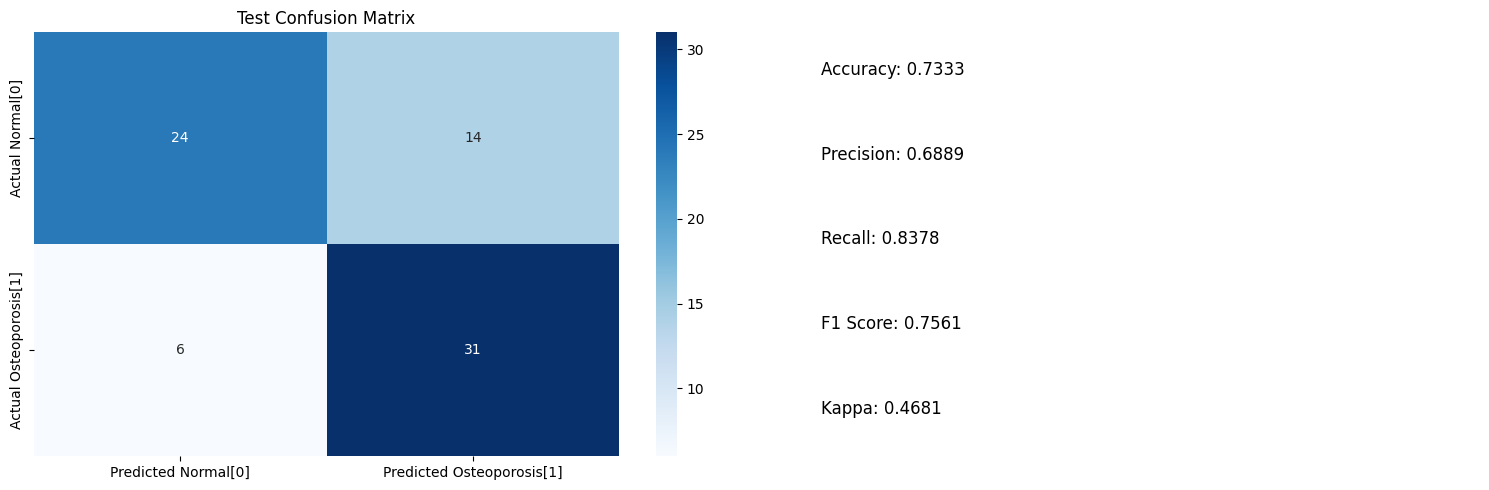

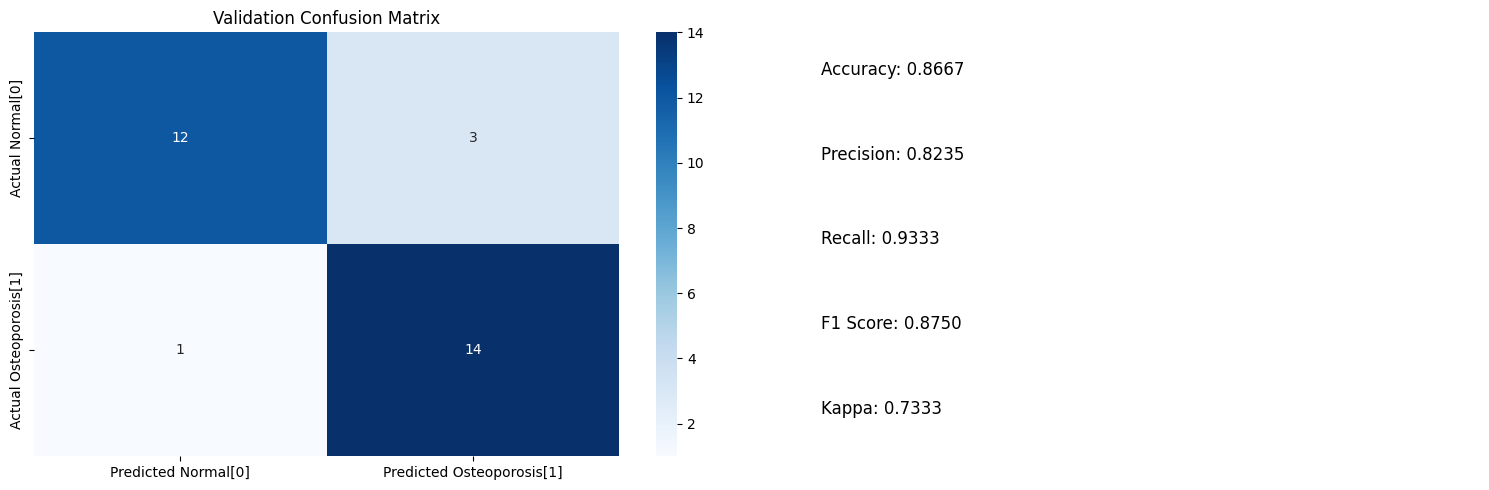

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal[0]', 'Predicted Osteoporosis[1]'],
                yticklabels=['Actual Normal[0]', 'Actual Osteoporosis[1]'])
    plt.title(f'{phase_name} Confusion Matrix')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision: {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall: {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score: {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy



# Evaluate both sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')


# ViT Large

In [ ]:
# Modified ViT Model without DWT Processing
class ViTBinaryClassifier(nn.Module):
    def __init__(self, pretrained_model='google/vit-large-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.vit.config.hidden_size, 1)  # Output for binary classification
        self.sigmoid = nn.Sigmoid()
        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Directly use the input images
        outputs = self.vit(x)
        # Use the output of the [CLS] token for classification
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.sigmoid(self.classifier(cls_output))

# Step 6: Create Datasets and DataLoaders
# (Assuming x_train, y_train, x_val, y_val, x_test, y_test are defined)
batch_size = 32
train_dataset = NumpyDataset(x_train, y_train, transform=transform)
val_dataset = NumpyDataset(x_val, y_val, transform=transform)
test_dataset = NumpyDataset(x_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 7: Initialize Model (AFTER device is defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTBinaryClassifier().to(device)

# Step 8: Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [ ]:
# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Shape: (batch_size, 1)
            loss = criterion(outputs.squeeze(), labels)  # Squeeze to match shape
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*batch_size)):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)  # Shape: (batch_size, 1)
                loss = criterion(outputs.squeeze(), labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0.5).float()  # Thresholding for binary classification
                correct += (predicted.squeeze() == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        improvement_msg = f"(▼ {best_val_loss - epoch_val_loss:.4f})"
    else:
        epochs_no_improve += 1
        improvement_msg = f"(▲ {epoch_val_loss - best_val_loss:.4f}) [Patience left: {patience - epochs_no_improve}]"
        if epochs_no_improve >= patience:
            early_stop = True

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start
    time_remaining = (epoch_time * (num_epochs - epoch - 1)) / 3600 if not early_stop else 0

    # Detailed epoch report
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Duration: {epoch_time:.1f}s | Remaining: ~{time_remaining:.1f}h")
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} {improvement_msg}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"-"*60)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Shape: (batch_size, 1)
            loss = criterion(outputs.squeeze(), labels)

            test_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()  # Thresholding for binary classification
            test_correct += (predicted.squeeze() == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.27s/batch, Loss=0.6764, Acc=0.5000]



Epoch   1/500 | Duration: 29.0s | Remaining: ~4.0h
Train Loss: 0.6974
Val Loss:   0.6764 (▼ 0.0000)
Val Acc:    0.5000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   2/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.22s/batch, Loss=0.6310, Acc=0.7000]



Epoch   2/500 | Duration: 15.3s | Remaining: ~2.1h
Train Loss: 0.6729
Val Loss:   0.6310 (▼ 0.0000)
Val Acc:    0.7000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   3/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.26s/batch, Loss=0.6133, Acc=0.7667]



Epoch   3/500 | Duration: 65.7s | Remaining: ~9.1h
Train Loss: 0.6363
Val Loss:   0.6133 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   4/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.5875, Acc=0.7000]



Epoch   4/500 | Duration: 17.7s | Remaining: ~2.4h
Train Loss: 0.6019
Val Loss:   0.5875 (▼ 0.0000)
Val Acc:    0.7000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   5/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.22s/batch, Loss=0.5583, Acc=0.7667]



Epoch   5/500 | Duration: 45.0s | Remaining: ~6.2h
Train Loss: 0.5913
Val Loss:   0.5583 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   6/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, Loss=0.5495, Acc=0.8000]



Epoch   6/500 | Duration: 18.1s | Remaining: ~2.5h
Train Loss: 0.5824
Val Loss:   0.5495 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   7/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.30s/batch, Loss=0.5355, Acc=0.8333]



Epoch   7/500 | Duration: 29.2s | Remaining: ~4.0h
Train Loss: 0.5650
Val Loss:   0.5355 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   8/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.27s/batch, Loss=0.5204, Acc=0.8000]



Epoch   8/500 | Duration: 15.3s | Remaining: ~2.1h
Train Loss: 0.5468
Val Loss:   0.5204 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   9/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.27s/batch, Loss=0.5096, Acc=0.7333]



Epoch   9/500 | Duration: 38.6s | Remaining: ~5.3h
Train Loss: 0.5404
Val Loss:   0.5096 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  10/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4993, Acc=0.8000]



Epoch  10/500 | Duration: 26.4s | Remaining: ~3.6h
Train Loss: 0.5290
Val Loss:   0.4993 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  11/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4926, Acc=0.8000]



Epoch  11/500 | Duration: 21.5s | Remaining: ~2.9h
Train Loss: 0.5237
Val Loss:   0.4926 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  12/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4873, Acc=0.7667]



Epoch  12/500 | Duration: 15.5s | Remaining: ~2.1h
Train Loss: 0.5155
Val Loss:   0.4873 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  13/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4847, Acc=0.8000]



Epoch  13/500 | Duration: 64.2s | Remaining: ~8.7h
Train Loss: 0.5083
Val Loss:   0.4847 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  14/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.24s/batch, Loss=0.4776, Acc=0.7333]



Epoch  14/500 | Duration: 15.6s | Remaining: ~2.1h
Train Loss: 0.5055
Val Loss:   0.4776 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  15/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.35s/batch, Loss=0.4801, Acc=0.8333]



Epoch  15/500 | Duration: 10.8s | Remaining: ~1.5h
Train Loss: 0.5097
Val Loss:   0.4801 (▲ 0.0025) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  16/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.22s/batch, Loss=0.4778, Acc=0.8000]



Epoch  16/500 | Duration: 10.7s | Remaining: ~1.4h
Train Loss: 0.4947
Val Loss:   0.4778 (▲ 0.0001) [Patience left: 18]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  17/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4698, Acc=0.7333]



Epoch  17/500 | Duration: 30.1s | Remaining: ~4.0h
Train Loss: 0.4928
Val Loss:   0.4698 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  18/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.19s/batch, Loss=0.4675, Acc=0.8000]



Epoch  18/500 | Duration: 37.6s | Remaining: ~5.0h
Train Loss: 0.4872
Val Loss:   0.4675 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  19/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.27s/batch, Loss=0.4640, Acc=0.7333]



Epoch  19/500 | Duration: 27.0s | Remaining: ~3.6h
Train Loss: 0.4826
Val Loss:   0.4640 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  20/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4591, Acc=0.7333]



Epoch  20/500 | Duration: 22.5s | Remaining: ~3.0h
Train Loss: 0.4790
Val Loss:   0.4591 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  21/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.30s/batch, Loss=0.4560, Acc=0.7333]



Epoch  21/500 | Duration: 27.0s | Remaining: ~3.6h
Train Loss: 0.4766
Val Loss:   0.4560 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  22/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4553, Acc=0.7333]



Epoch  22/500 | Duration: 25.6s | Remaining: ~3.4h
Train Loss: 0.4786
Val Loss:   0.4553 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  23/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4559, Acc=0.8333]



Epoch  23/500 | Duration: 10.7s | Remaining: ~1.4h
Train Loss: 0.4755
Val Loss:   0.4559 (▲ 0.0006) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  24/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, Loss=0.4546, Acc=0.7667]



Epoch  24/500 | Duration: 15.4s | Remaining: ~2.0h
Train Loss: 0.4654
Val Loss:   0.4546 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  25/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4495, Acc=0.7333]



Epoch  25/500 | Duration: 35.0s | Remaining: ~4.6h
Train Loss: 0.4679
Val Loss:   0.4495 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  26/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.25s/batch, Loss=0.4493, Acc=0.8333]



Epoch  26/500 | Duration: 17.8s | Remaining: ~2.3h
Train Loss: 0.4618
Val Loss:   0.4493 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  27/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.25s/batch, Loss=0.4462, Acc=0.7667]



Epoch  27/500 | Duration: 16.9s | Remaining: ~2.2h
Train Loss: 0.4601
Val Loss:   0.4462 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  28/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, Loss=0.4483, Acc=0.7667]



Epoch  28/500 | Duration: 10.7s | Remaining: ~1.4h
Train Loss: 0.4604
Val Loss:   0.4483 (▲ 0.0021) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  29/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4484, Acc=0.8000]



Epoch  29/500 | Duration: 10.6s | Remaining: ~1.4h
Train Loss: 0.4594
Val Loss:   0.4484 (▲ 0.0022) [Patience left: 18]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  30/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4470, Acc=0.7667]



Epoch  30/500 | Duration: 10.6s | Remaining: ~1.4h
Train Loss: 0.4520
Val Loss:   0.4470 (▲ 0.0009) [Patience left: 17]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  31/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.19s/batch, Loss=0.4431, Acc=0.7667]



Epoch  31/500 | Duration: 37.5s | Remaining: ~4.9h
Train Loss: 0.4519
Val Loss:   0.4431 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  32/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.24s/batch, Loss=0.4423, Acc=0.7667]



Epoch  32/500 | Duration: 20.6s | Remaining: ~2.7h
Train Loss: 0.4494
Val Loss:   0.4423 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  33/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4416, Acc=0.7667]



Epoch  33/500 | Duration: 30.6s | Remaining: ~4.0h
Train Loss: 0.4467
Val Loss:   0.4416 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  34/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.32s/batch, Loss=0.4406, Acc=0.7667]



Epoch  34/500 | Duration: 21.7s | Remaining: ~2.8h
Train Loss: 0.4452
Val Loss:   0.4406 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  35/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4414, Acc=0.8000]



Epoch  35/500 | Duration: 10.7s | Remaining: ~1.4h
Train Loss: 0.4538
Val Loss:   0.4414 (▲ 0.0009) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  36/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4439, Acc=0.7667]



Epoch  36/500 | Duration: 10.6s | Remaining: ~1.4h
Train Loss: 0.4431
Val Loss:   0.4439 (▲ 0.0033) [Patience left: 18]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  37/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.30s/batch, Loss=0.4397, Acc=0.7667]



Epoch  37/500 | Duration: 15.2s | Remaining: ~2.0h
Train Loss: 0.4401
Val Loss:   0.4397 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  38/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4387, Acc=0.7667]



Epoch  38/500 | Duration: 17.6s | Remaining: ~2.3h
Train Loss: 0.4363
Val Loss:   0.4387 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  39/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.26s/batch, Loss=0.4383, Acc=0.7667]



Epoch  39/500 | Duration: 18.4s | Remaining: ~2.4h
Train Loss: 0.4348
Val Loss:   0.4383 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  40/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4380, Acc=0.7667]



Epoch  40/500 | Duration: 16.5s | Remaining: ~2.1h
Train Loss: 0.4363
Val Loss:   0.4380 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  41/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.22s/batch, Loss=0.4364, Acc=0.7667]



Epoch  41/500 | Duration: 16.5s | Remaining: ~2.1h
Train Loss: 0.4314
Val Loss:   0.4364 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  42/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, Loss=0.4379, Acc=0.8000]



Epoch  42/500 | Duration: 10.8s | Remaining: ~1.4h
Train Loss: 0.4290
Val Loss:   0.4379 (▲ 0.0015) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  43/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4346, Acc=0.7667]



Epoch  43/500 | Duration: 22.5s | Remaining: ~2.9h
Train Loss: 0.4283
Val Loss:   0.4346 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  44/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.24s/batch, Loss=0.4352, Acc=0.7667]



Epoch  44/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.4264
Val Loss:   0.4352 (▲ 0.0006) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  45/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4332, Acc=0.7667]



Epoch  45/500 | Duration: 15.3s | Remaining: ~1.9h
Train Loss: 0.4263
Val Loss:   0.4332 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  46/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4323, Acc=0.7667]



Epoch  46/500 | Duration: 27.7s | Remaining: ~3.5h
Train Loss: 0.4247
Val Loss:   0.4323 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  47/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, Loss=0.4353, Acc=0.7667]



Epoch  47/500 | Duration: 10.5s | Remaining: ~1.3h
Train Loss: 0.4299
Val Loss:   0.4353 (▲ 0.0031) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  48/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.23s/batch, Loss=0.4350, Acc=0.8333]



Epoch  48/500 | Duration: 10.7s | Remaining: ~1.3h
Train Loss: 0.4263
Val Loss:   0.4350 (▲ 0.0027) [Patience left: 18]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  49/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4301, Acc=0.7667]



Epoch  49/500 | Duration: 22.0s | Remaining: ~2.8h
Train Loss: 0.4193
Val Loss:   0.4301 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  50/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4323, Acc=0.7667]



Epoch  50/500 | Duration: 10.8s | Remaining: ~1.3h
Train Loss: 0.4206
Val Loss:   0.4323 (▲ 0.0022) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  51/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4311, Acc=0.8000]



Epoch  51/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.4137
Val Loss:   0.4311 (▲ 0.0010) [Patience left: 18]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  52/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4306, Acc=0.8000]



Epoch  52/500 | Duration: 10.5s | Remaining: ~1.3h
Train Loss: 0.4168
Val Loss:   0.4306 (▲ 0.0005) [Patience left: 17]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  53/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4317, Acc=0.7667]



Epoch  53/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.4128
Val Loss:   0.4317 (▲ 0.0016) [Patience left: 16]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  54/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4294, Acc=0.7667]



Epoch  54/500 | Duration: 31.5s | Remaining: ~3.9h
Train Loss: 0.4110
Val Loss:   0.4294 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  55/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4291, Acc=0.8000]



Epoch  55/500 | Duration: 29.3s | Remaining: ~3.6h
Train Loss: 0.4098
Val Loss:   0.4291 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  56/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4272, Acc=0.7667]



Epoch  56/500 | Duration: 20.8s | Remaining: ~2.6h
Train Loss: 0.4089
Val Loss:   0.4272 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  57/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.22s/batch, Loss=0.4254, Acc=0.7333]



Epoch  57/500 | Duration: 20.1s | Remaining: ~2.5h
Train Loss: 0.4071
Val Loss:   0.4254 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  58/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4232, Acc=0.8000]



Epoch  58/500 | Duration: 18.5s | Remaining: ~2.3h
Train Loss: 0.4069
Val Loss:   0.4232 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  59/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4244, Acc=0.8000]



Epoch  59/500 | Duration: 10.5s | Remaining: ~1.3h
Train Loss: 0.4089
Val Loss:   0.4244 (▲ 0.0012) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  60/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.30s/batch, Loss=0.4250, Acc=0.7667]



Epoch  60/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.4035
Val Loss:   0.4250 (▲ 0.0018) [Patience left: 18]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  61/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4235, Acc=0.8000]



Epoch  61/500 | Duration: 10.7s | Remaining: ~1.3h
Train Loss: 0.4076
Val Loss:   0.4235 (▲ 0.0003) [Patience left: 17]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  62/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4236, Acc=0.7667]



Epoch  62/500 | Duration: 10.5s | Remaining: ~1.3h
Train Loss: 0.4009
Val Loss:   0.4236 (▲ 0.0004) [Patience left: 16]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  63/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4260, Acc=0.7667]



Epoch  63/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.4035
Val Loss:   0.4260 (▲ 0.0028) [Patience left: 15]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  64/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.19s/batch, Loss=0.4258, Acc=0.7667]



Epoch  64/500 | Duration: 10.5s | Remaining: ~1.3h
Train Loss: 0.4021
Val Loss:   0.4258 (▲ 0.0026) [Patience left: 14]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  65/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.24s/batch, Loss=0.4240, Acc=0.7667]



Epoch  65/500 | Duration: 10.5s | Remaining: ~1.3h
Train Loss: 0.3999
Val Loss:   0.4240 (▲ 0.0007) [Patience left: 13]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  66/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4231, Acc=0.7667]



Epoch  66/500 | Duration: 20.9s | Remaining: ~2.5h
Train Loss: 0.3979
Val Loss:   0.4231 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  67/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.18s/batch, Loss=0.4226, Acc=0.7333]



Epoch  67/500 | Duration: 15.1s | Remaining: ~1.8h
Train Loss: 0.3968
Val Loss:   0.4226 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  68/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4225, Acc=0.7667]



Epoch  68/500 | Duration: 16.4s | Remaining: ~2.0h
Train Loss: 0.3963
Val Loss:   0.4225 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  69/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4225, Acc=0.7667]



Epoch  69/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.3965
Val Loss:   0.4225 (▲ 0.0000) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  70/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4224, Acc=0.7667]



Epoch  70/500 | Duration: 16.4s | Remaining: ~2.0h
Train Loss: 0.3960
Val Loss:   0.4224 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  71/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4224, Acc=0.7667]



Epoch  71/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3959
Val Loss:   0.4224 (▲ 0.0000) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  72/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.28s/batch, Loss=0.4223, Acc=0.8000]



Epoch  72/500 | Duration: 16.8s | Remaining: ~2.0h
Train Loss: 0.3956
Val Loss:   0.4223 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  73/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.26s/batch, Loss=0.4224, Acc=0.7667]



Epoch  73/500 | Duration: 10.7s | Remaining: ~1.3h
Train Loss: 0.3955
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  74/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.33s/batch, Loss=0.4224, Acc=0.7667]



Epoch  74/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3956
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 18]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  75/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4226, Acc=0.7667]



Epoch  75/500 | Duration: 10.6s | Remaining: ~1.3h
Train Loss: 0.3960
Val Loss:   0.4226 (▲ 0.0003) [Patience left: 17]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  76/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.22s/batch, Loss=0.4226, Acc=0.7667]



Epoch  76/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3951
Val Loss:   0.4226 (▲ 0.0003) [Patience left: 16]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  77/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.30s/batch, Loss=0.4225, Acc=0.7667]



Epoch  77/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3952
Val Loss:   0.4225 (▲ 0.0002) [Patience left: 15]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  78/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4224, Acc=0.7667]



Epoch  78/500 | Duration: 10.6s | Remaining: ~1.2h
Train Loss: 0.3950
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 14]
Val Acc:    0.7667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  79/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.18s/batch, Loss=0.4224, Acc=0.7667]



Epoch  79/500 | Duration: 10.4s | Remaining: ~1.2h
Train Loss: 0.3949
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 13]
Val Acc:    0.7667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  80/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4224, Acc=0.7667]



Epoch  80/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3949
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 12]
Val Acc:    0.7667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  81/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.18s/batch, Loss=0.4225, Acc=0.7667]



Epoch  81/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3949
Val Loss:   0.4225 (▲ 0.0002) [Patience left: 11]
Val Acc:    0.7667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  82/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4225, Acc=0.7667]



Epoch  82/500 | Duration: 10.4s | Remaining: ~1.2h
Train Loss: 0.3949
Val Loss:   0.4225 (▲ 0.0001) [Patience left: 10]
Val Acc:    0.7667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  83/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.24s/batch, Loss=0.4224, Acc=0.7667]



Epoch  83/500 | Duration: 10.4s | Remaining: ~1.2h
Train Loss: 0.3949
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 9]
Val Acc:    0.7667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  84/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4224, Acc=0.7667]



Epoch  84/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 8]
Val Acc:    0.7667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  85/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch, Loss=0.4224, Acc=0.7667]



Epoch  85/500 | Duration: 10.7s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 7]
Val Acc:    0.7667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  86/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.25s/batch, Loss=0.4224, Acc=0.7667]



Epoch  86/500 | Duration: 10.6s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 6]
Val Acc:    0.7667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  87/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.31s/batch, Loss=0.4224, Acc=0.7667]



Epoch  87/500 | Duration: 10.6s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 5]
Val Acc:    0.7667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  88/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.21s/batch, Loss=0.4224, Acc=0.7667]



Epoch  88/500 | Duration: 10.6s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 4]
Val Acc:    0.7667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  89/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.27s/batch, Loss=0.4224, Acc=0.7667]



Epoch  89/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 3]
Val Acc:    0.7667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  90/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.29s/batch, Loss=0.4224, Acc=0.7667]



Epoch  90/500 | Duration: 10.5s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 2]
Val Acc:    0.7667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  91/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.18s/batch, Loss=0.4224, Acc=0.7667]



Epoch  91/500 | Duration: 10.6s | Remaining: ~1.2h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 1]
Val Acc:    0.7667
Learning Rate: 1.00e-07
------------------------------------------------------------


Epoch  92/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.26s/batch, Loss=0.4224, Acc=0.7667]
<ipython-input-11-ea554c8b544c>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat


Epoch  92/500 | Duration: 10.5s | Remaining: ~0.0h
Train Loss: 0.3948
Val Loss:   0.4224 (▲ 0.0001) [Patience left: 0]
Val Acc:    0.7667
Learning Rate: 1.00e-07
------------------------------------------------------------
[!] Early stopping triggered at epoch 93

Loaded best model weights for final testing


Final Testing: 100%|██████████| 3/3 [00:02<00:00,  1.07batch/s, Loss=0.3899, Acc=0.7733]


Final Test Results:
Loss: 0.4636
Accuracy: 0.7733


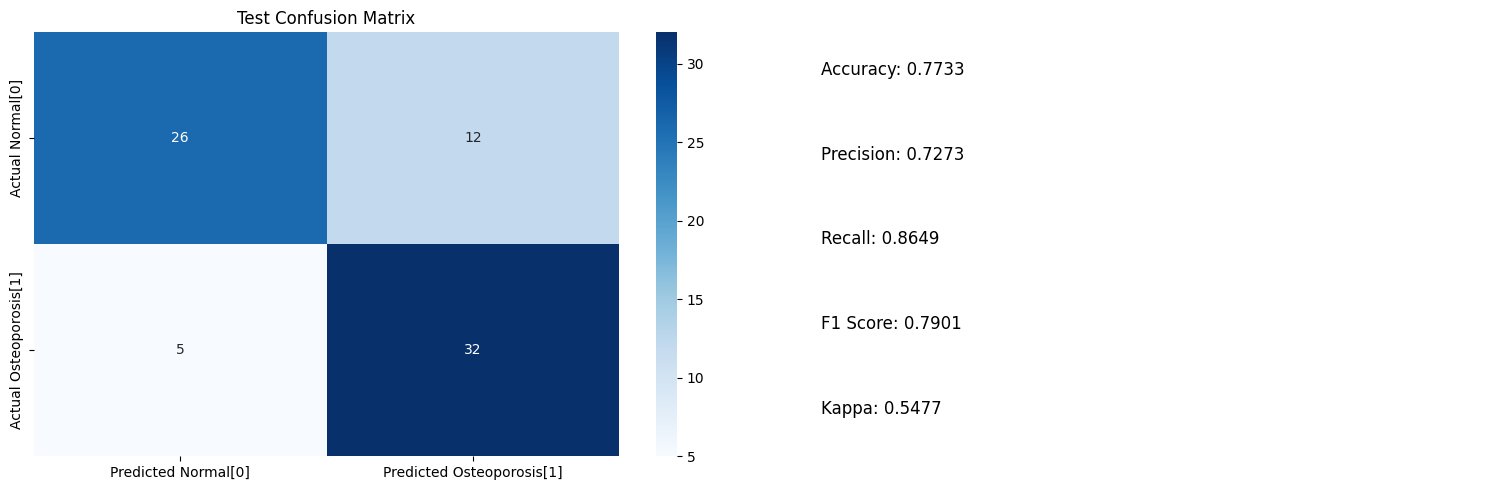

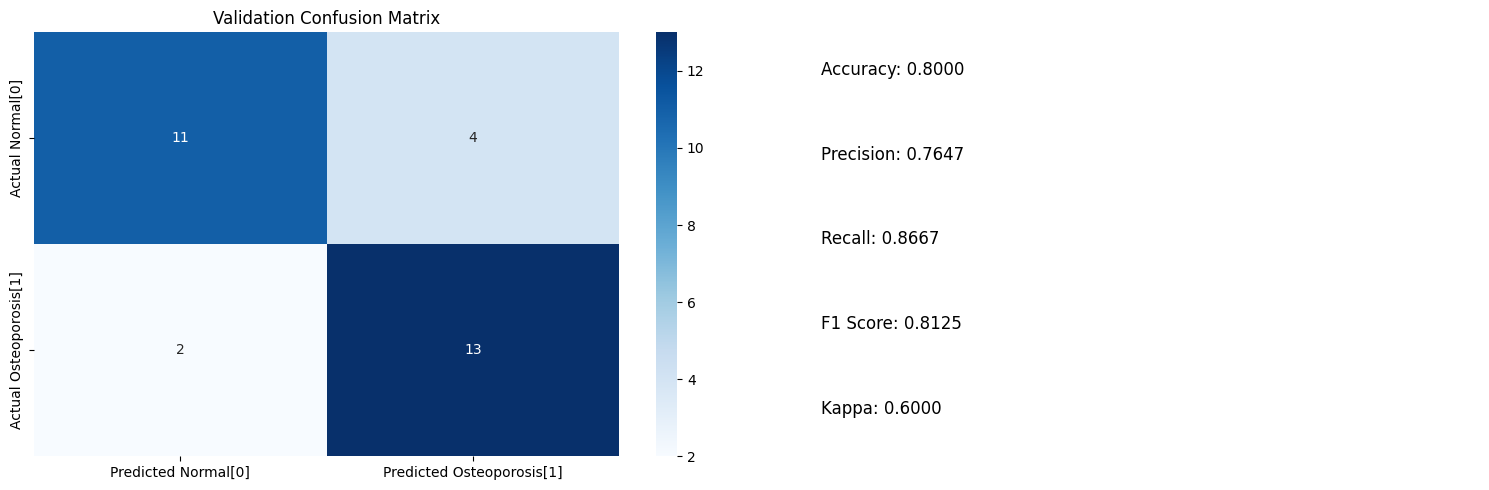

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal[0]', 'Predicted Osteoporosis[1]'],
                yticklabels=['Actual Normal[0]', 'Actual Osteoporosis[1]'])
    plt.title(f'{phase_name} Confusion Matrix')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision: {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall: {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score: {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy



# Evaluate both sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')
